In [1]:
# import required packages
import keras
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import pickle
import matplotlib.pyplot as plt
import numpy as np
tf.keras.backend.set_floatx('float32')
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from matplotlib.pyplot import imshow
%matplotlib inline
import pandas as pd
from keras.callbacks import ModelCheckpoint

K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


In [2]:
# obtain train/val/test sets
with open('x_train_movieposter.txt', 'rb') as file:
    X_train = np.array(pickle.load(file))
with open('x_val_movieposter.txt', 'rb') as file:
    X_val = np.array(pickle.load(file))
with open('x_test_movieposter.txt', 'rb') as file:
    X_test = np.array(pickle.load(file))
with open('y_test2_movieposter.txt', 'rb') as file:
    Y_test = np.array(pickle.load(file))
with open('y_val2_movieposter.txt', 'rb') as file:
    Y_val = np.array(pickle.load(file))
with open('y_train2_movieposter.txt', 'rb') as file:
    Y_train = np.array(pickle.load(file))


In [ ]:
# check the dimension of each set
X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

In [4]:
# preprocess the inputs
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [5]:
# recall deep learning model without the fully connected layer
vgg16 = VGG16(input_shape = (256, 256, 3), include_top=False, weights='imagenet', pooling='max')

In [6]:
# build fully connected layer with the last layer composed of 7 nodes/genres
model = models.Sequential()
model.add(vgg16)
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(7, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 903       
Total params: 15,372,103
Trainable params: 15,372,103
Non-trainable params: 0
_________________________________________________________________


In [7]:
# check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.training.Model object at 0x7f9f30270d30> True
<keras.layers.core.Dense object at 0x7f9f30284a58> True
<keras.layers.core.Dense object at 0x7f9f3021ee80> True
<keras.layers.core.Dense object at 0x7f9f30284ef0> True


In [8]:
# count the total number for each genres
ytrain_df = pd.DataFrame(Y_train2)
ytrain_df.sum(axis=0)

0    15152
1     9510
2     4733
3     3997
4     4004
5     3669
6     4573
dtype: int64

In [9]:
# compose class weights on imbalanced dataset
nclasses = 7
bincount = np.array([15152, 9510, 4733, 3997, 4004, 3669, 4573])
class_weights = {k: len(Y_train)/(nclasses*bincount[k]) for k in range(nclasses)}
genres = ['Drama', 'Comedy', 'Romance', 'Action', 'Crime', 'Thriller', 'Others']

In [10]:
# check class weights
class_weights

{0: 0.28178269723940264,
 1: 0.44895598617996096,
 2: 0.9020856599559325,
 3: 1.0681940026448409,
 4: 1.066326530612245,
 5: 1.1636880426741425,
 6: 0.9336478085658055}

In [11]:
# compile model 
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# schedule the learning rate during the training of the model
def scheduler(epoch):
    """ Schedule the learning rate during the training of the model.
    
        Input:
            epoch (int)
        Output:
            learning_rate (float)
    """    
    if epoch <= 20:
        return 0.001
    else:
        return 0.001 * np.exp(0.1*(20 - epoch))

lr_scheduler = keras.callbacks.callbacks.LearningRateScheduler(scheduler)

In [13]:
# save the best model with weigths after each epoch
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,save_best_only=True, mode='auto', period=1)

In [14]:
# train the model
hist = model.fit(X_train, Y_train2, batch_size=32, epochs=10, callbacks=[checkpoint, lr_scheduler], class_weight=class_weights, validation_data=(X_val, Y_val2))
model.summary()

Train on 29887 samples, validate on 3321 samples
Epoch 1/10
29887/29887 [==============================] - 1070s 36ms/step - loss: 0.2731 - accuracy: 0.7808 - val_loss: 0.4879 - val_accuracy: 0.7826

Epoch 00001: loss improved from inf to 0.27308, saving model to best_model.hdf5
Epoch 2/10
29887/29887 [==============================] - 1040s 35ms/step - loss: 0.2476 - accuracy: 0.7820 - val_loss: 0.4889 - val_accuracy: 0.7827

Epoch 00002: loss improved from 0.27308 to 0.24762, saving model to best_model.hdf5
Epoch 3/10
29887/29887 [==============================] - 1041s 35ms/step - loss: 0.2464 - accuracy: 0.7822 - val_loss: 0.4931 - val_accuracy: 0.7826

Epoch 00003: loss improved from 0.24762 to 0.24642, saving model to best_model.hdf5
Epoch 4/10
29887/29887 [==============================] - 1042s 35ms/step - loss: 0.2459 - accuracy: 0.7827 - val_loss: 0.5072 - val_accuracy: 0.7828

Epoch 00004: loss improved from 0.24642 to 0.24593, saving model to best_model.hdf5
Epoch 5/10
2988

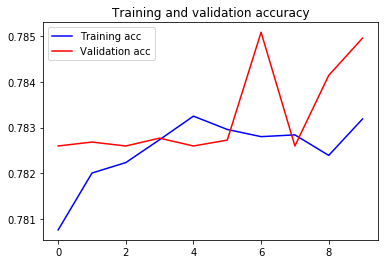

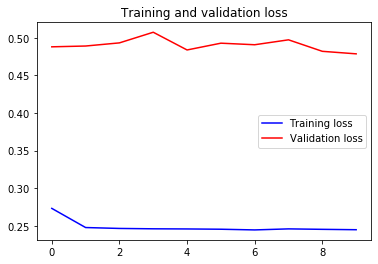

In [15]:
# plot training & validation accuracy and loss
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('Training and validation loss')
plt.show()



In [106]:
# make prediction on test set
prediction = model.predict(X_test)

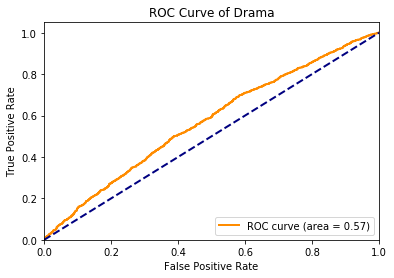

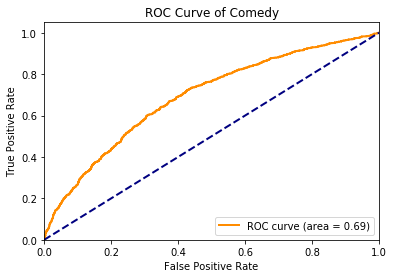

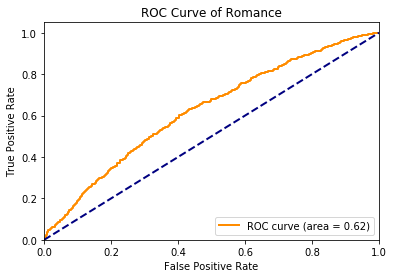

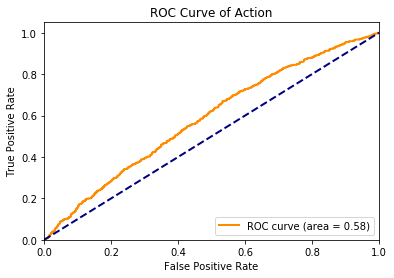

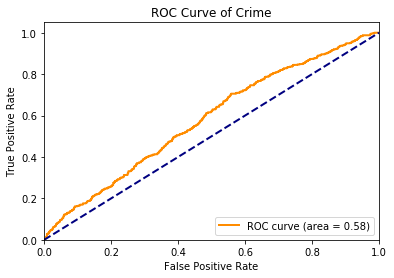

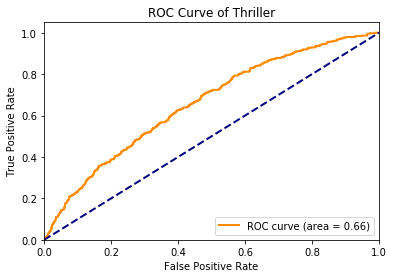

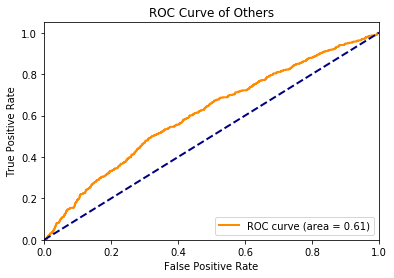

In [19]:
# plot ROC curve 

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
 
n_classes = 7  #number of genres
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(Y_test2[:])[:,i], np.array(prediction[:])[:,i]) #use prediction probabilty 
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test2.ravel(), prediction.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve of ' + str(genres[i]))
    plt.legend(loc="lower right")
    plt.savefig('ROC Curve of ' + str(genres[i]))
    plt.show()

<Figure size 432x288 with 0 Axes>

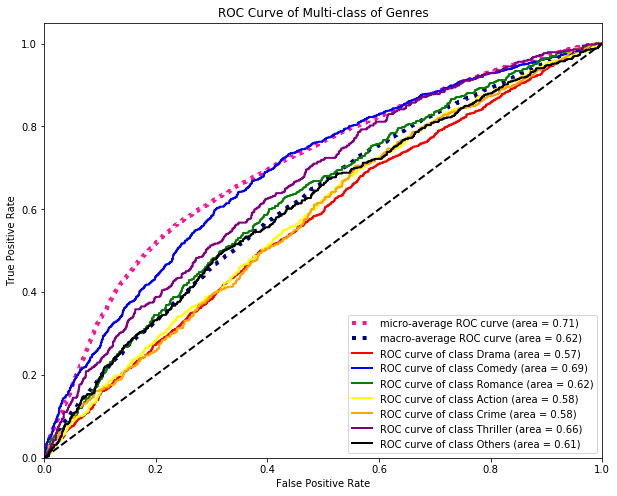

In [20]:
# plot ROC curves of each genre in one plot
# first aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# plot all ROC curves
plt.figure()
plt.figure(figsize=[10, 8])
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'black']
for i, colors in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=colors, lw=2,
             label='ROC curve of class ' + str(genres[i])+ ' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Multi-class of Genres')
plt.legend(loc="lower right")
plt.savefig('ROC_Curve_of_Multi-class_of_Genres')
plt.show()

In [107]:
# assign decision thresholds for each genre
pred = []
threshold = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]
for i in range(n_classes):
    y = np.array(prediction)[:,i]
    y[y >= threshold[i]] = 1
    y[y < threshold[i]] = 0
    pred.append(y)
pred = np.array(pred).transpose()

In [108]:
# calculate f1, precision, recall score for each genre
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
f1 = dict()
precision = dict()
recall = dict()
for i in range(n_classes):
    f1[i] = f1_score(np.array(Y_test2)[:,i], np.array(pred)[:,i], average='macro')
    f1[i] = f1_score(np.array(Y_test2)[:,i], np.array(pred)[:,i], average='micro')
    precision[i] = precision_score(np.array(Y_test2)[:,i], np.array(pred)[:,i])
    recall[i] = recall_score(np.array(Y_test2)[:,i], np.array(pred)[:,i])
    

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
# calculate perfect score = the number of correct genre(s) of a movie / total number of movies
counter = 0
for i in range(len(pred)):
    inner_counter = 0
    for j in range(7):
        if int(pred[i][j]) == Y_test2[i][j]:
            inner_counter += 1
    if inner_counter >= 7:
        counter += 1
                
perfectscore = counter / len(pred)
perfectscore

0.15176151761517614